# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

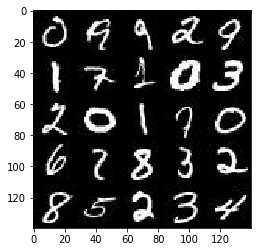

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

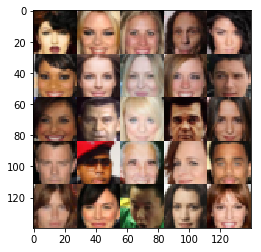

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * h1, h1)
        #print ('Layer 1:', lrelu1.shape)
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding="SAME",
                              kernel_initializer =tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding="SAME", 
                             kernel_initializer =tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', lrelu3.shape)
        
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2,):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function 
        
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        h1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        #print ('Layer 1:', lrelu1.shape)
        # 2x2x512 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d_transpose(lrelu1, 256, 3, strides=2, padding="SAME")
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 4x4x256 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d_transpose(lrelu2, 128, 4, strides=1, padding='VALID')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', h3.shape)
        # 7x7x128
        
        # Hidden Layer 4
        h4 = tf.layers.conv2d_transpose(lrelu3, 64, 3, strides=2, padding='SAME')
        bn4 = tf.layers.batch_normalization(h4, training=is_train)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        #print ('Layer 3:', h4.shape)
        # 14x14x64
        
        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, strides=2, padding="SAME")
        
        out = tf.tanh(logits)
        #print ('Output:',logits.shape)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    # Generator network 
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # Disriminator network
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
     labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
     labels=tf.zeros_like(d_logits_real)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    # https://blog.metaflow.fr/tensorflow-mutating-variables-and-control-flow-2181dd238e62
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model   
    
    # Set the image width, height, and image channels
    _, image_width, image_height, image_channels = data_shape
    
    # Impliment model_inputs and set the input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Impliment model_loss and set the d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Impliment model_opt and set d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set batch counter
    batch_count = 0
    
    # Set number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch_count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4777... Generator Loss: 2.2389
Epoch 1/2... Discriminator Loss: 0.4406... Generator Loss: 2.4791
Epoch 1/2... Discriminator Loss: 0.5301... Generator Loss: 2.9052
Epoch 1/2... Discriminator Loss: 3.6175... Generator Loss: 0.0488
Epoch 1/2... Discriminator Loss: 0.7363... Generator Loss: 3.5509
Epoch 1/2... Discriminator Loss: 2.1172... Generator Loss: 0.2048
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 1.3530
Epoch 1/2... Discriminator Loss: 0.7610... Generator Loss: 1.8689
Epoch 1/2... Discriminator Loss: 0.5485... Generator Loss: 2.2520
Epoch 1/2... Discriminator Loss: 0.4822... Generator Loss: 2.7722


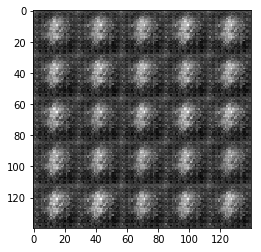

Epoch 1/2... Discriminator Loss: 0.5290... Generator Loss: 2.5959
Epoch 1/2... Discriminator Loss: 0.5726... Generator Loss: 2.1440
Epoch 1/2... Discriminator Loss: 0.4297... Generator Loss: 3.5924
Epoch 1/2... Discriminator Loss: 0.4924... Generator Loss: 2.5618
Epoch 1/2... Discriminator Loss: 0.4296... Generator Loss: 3.3405
Epoch 1/2... Discriminator Loss: 0.4269... Generator Loss: 3.0687
Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 3.9392
Epoch 1/2... Discriminator Loss: 0.3793... Generator Loss: 3.8765
Epoch 1/2... Discriminator Loss: 0.3864... Generator Loss: 3.5836
Epoch 1/2... Discriminator Loss: 0.4188... Generator Loss: 3.3701


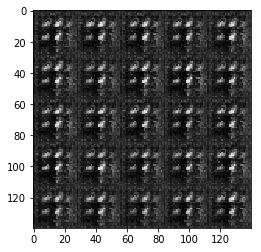

Epoch 1/2... Discriminator Loss: 0.4293... Generator Loss: 3.3427
Epoch 1/2... Discriminator Loss: 0.4396... Generator Loss: 2.9704
Epoch 1/2... Discriminator Loss: 0.3984... Generator Loss: 3.8778
Epoch 1/2... Discriminator Loss: 0.3985... Generator Loss: 3.9210
Epoch 1/2... Discriminator Loss: 0.4097... Generator Loss: 3.0550
Epoch 1/2... Discriminator Loss: 0.4654... Generator Loss: 2.8968
Epoch 1/2... Discriminator Loss: 0.6076... Generator Loss: 4.6038
Epoch 1/2... Discriminator Loss: 0.5096... Generator Loss: 3.3115
Epoch 1/2... Discriminator Loss: 0.4376... Generator Loss: 3.3844
Epoch 1/2... Discriminator Loss: 0.4583... Generator Loss: 3.2473


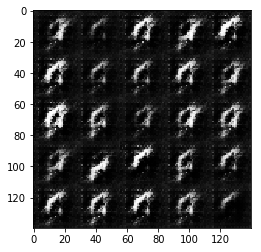

Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 3.0494
Epoch 1/2... Discriminator Loss: 0.4667... Generator Loss: 2.7395
Epoch 1/2... Discriminator Loss: 0.4373... Generator Loss: 3.3634
Epoch 1/2... Discriminator Loss: 0.4702... Generator Loss: 2.8209
Epoch 1/2... Discriminator Loss: 0.4787... Generator Loss: 2.8550
Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 4.0674
Epoch 1/2... Discriminator Loss: 0.4630... Generator Loss: 3.4236
Epoch 1/2... Discriminator Loss: 0.4651... Generator Loss: 2.9599
Epoch 1/2... Discriminator Loss: 0.4619... Generator Loss: 2.9713
Epoch 1/2... Discriminator Loss: 0.4782... Generator Loss: 2.6347


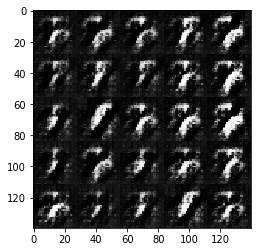

Epoch 1/2... Discriminator Loss: 0.4934... Generator Loss: 2.4042
Epoch 1/2... Discriminator Loss: 0.4929... Generator Loss: 2.3742
Epoch 1/2... Discriminator Loss: 0.4442... Generator Loss: 4.4234
Epoch 1/2... Discriminator Loss: 0.5102... Generator Loss: 2.3554
Epoch 1/2... Discriminator Loss: 0.4387... Generator Loss: 2.9088
Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 2.8229
Epoch 2/2... Discriminator Loss: 0.4153... Generator Loss: 3.5670
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 7.6428
Epoch 2/2... Discriminator Loss: 0.6453... Generator Loss: 1.8366
Epoch 2/2... Discriminator Loss: 0.6107... Generator Loss: 3.2051


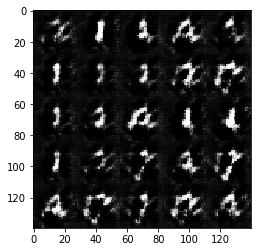

Epoch 2/2... Discriminator Loss: 0.4625... Generator Loss: 3.1145
Epoch 2/2... Discriminator Loss: 0.5490... Generator Loss: 2.1190
Epoch 2/2... Discriminator Loss: 0.4765... Generator Loss: 2.6601
Epoch 2/2... Discriminator Loss: 0.5240... Generator Loss: 3.7906
Epoch 2/2... Discriminator Loss: 0.5254... Generator Loss: 2.3808
Epoch 2/2... Discriminator Loss: 0.8284... Generator Loss: 5.2375
Epoch 2/2... Discriminator Loss: 0.4536... Generator Loss: 3.3306
Epoch 2/2... Discriminator Loss: 0.5014... Generator Loss: 2.8011
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 3.2338
Epoch 2/2... Discriminator Loss: 0.6537... Generator Loss: 3.4455


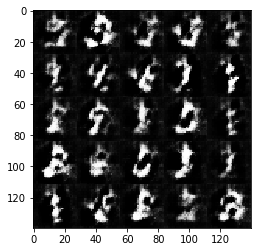

Epoch 2/2... Discriminator Loss: 0.5316... Generator Loss: 2.4642
Epoch 2/2... Discriminator Loss: 0.5571... Generator Loss: 3.1646
Epoch 2/2... Discriminator Loss: 0.6186... Generator Loss: 4.1797
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 1.8662
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 1.7598
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.5601
Epoch 2/2... Discriminator Loss: 0.5230... Generator Loss: 2.8361
Epoch 2/2... Discriminator Loss: 0.6776... Generator Loss: 2.6493
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 4.9299
Epoch 2/2... Discriminator Loss: 0.7140... Generator Loss: 1.7823


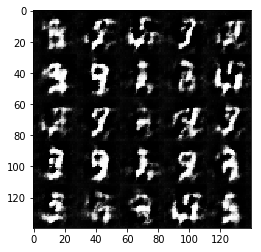

Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 3.0497
Epoch 2/2... Discriminator Loss: 0.6053... Generator Loss: 2.2164
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 5.4069
Epoch 2/2... Discriminator Loss: 0.5562... Generator Loss: 2.4971
Epoch 2/2... Discriminator Loss: 0.7104... Generator Loss: 1.5023
Epoch 2/2... Discriminator Loss: 0.5790... Generator Loss: 2.6006
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 3.4806
Epoch 2/2... Discriminator Loss: 0.5881... Generator Loss: 2.9557
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 1.7655
Epoch 2/2... Discriminator Loss: 0.6834... Generator Loss: 1.9400


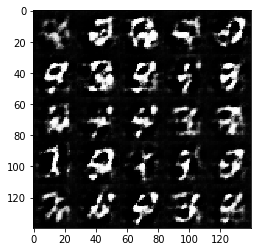

Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 2.5526
Epoch 2/2... Discriminator Loss: 0.5566... Generator Loss: 3.1142
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 3.3770
Epoch 2/2... Discriminator Loss: 0.7316... Generator Loss: 1.4445
Epoch 2/2... Discriminator Loss: 0.5695... Generator Loss: 2.2788
Epoch 2/2... Discriminator Loss: 0.5827... Generator Loss: 2.0228
Epoch 2/2... Discriminator Loss: 0.7484... Generator Loss: 1.8644
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 4.6917
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 1.5663
Epoch 2/2... Discriminator Loss: 0.5519... Generator Loss: 2.2412


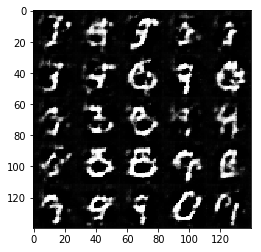

Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.5771
Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 2.1776
Epoch 2/2... Discriminator Loss: 0.5595... Generator Loss: 2.4647


In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.6406
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 1.7633
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 2.4020
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 2.4966
Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 2.7673
Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 2.8647
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 2.9169
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 2.5357
Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 3.4549
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 2.4275


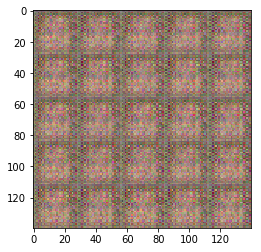

Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 3.3919
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 2.5642
Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 2.4940
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 3.5327
Epoch 1/1... Discriminator Loss: 0.4633... Generator Loss: 2.7160
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 3.6997
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 3.7276
Epoch 1/1... Discriminator Loss: 0.4285... Generator Loss: 2.9113
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 3.2304
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.5870


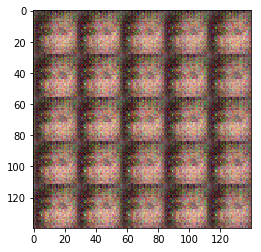

Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 3.5639
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 4.4875
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 3.4978
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 2.9218
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 3.8191
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 3.2800
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 4.1211
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 4.2767
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 3.8794
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 3.3285


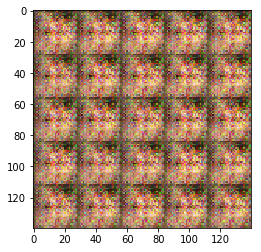

Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 3.8074
Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 4.0597
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 3.3454
Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 3.5511
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 4.5132
Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 4.3894
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 4.5213
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 2.9998
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 4.2514
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 3.9363


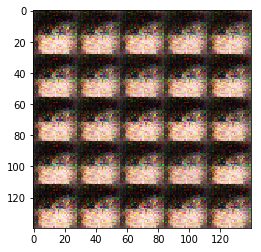

Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 4.4137
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 4.1147
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 3.6909
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 4.2351
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 4.9705
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 4.2227
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 4.4105
Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 4.5317
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 4.1310
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 3.5594


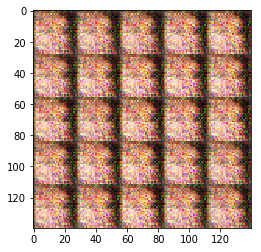

Epoch 1/1... Discriminator Loss: 0.3583... Generator Loss: 4.5418
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 4.6421
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 4.4294
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 4.9679
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 4.7313
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 5.2015
Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 5.1073
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 4.8660
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 4.4786
Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 4.1595


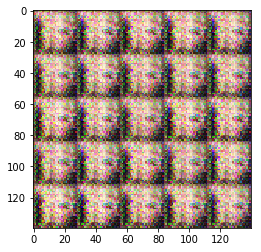

Epoch 1/1... Discriminator Loss: 0.3531... Generator Loss: 6.2261
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 5.2130
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 4.8924
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 4.6264
Epoch 1/1... Discriminator Loss: 0.3511... Generator Loss: 4.3527
Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 4.2839
Epoch 1/1... Discriminator Loss: 0.3530... Generator Loss: 4.4881
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 4.7623
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 4.0629
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.0359


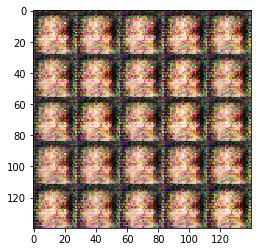

Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 3.9406
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 4.4401
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 4.3014
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 3.7619
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 5.4705
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 5.2572
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 2.1315
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.5563
Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 3.1004


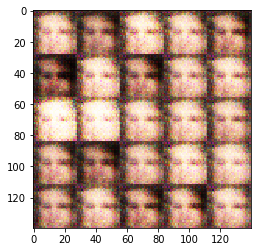

Epoch 1/1... Discriminator Loss: 0.5457... Generator Loss: 2.4672
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 4.0185
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 4.6763
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 3.1864
Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 2.4888
Epoch 1/1... Discriminator Loss: 0.5662... Generator Loss: 4.7123
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 2.9143
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 3.4970
Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 1.9246
Epoch 1/1... Discriminator Loss: 0.5197... Generator Loss: 2.1447


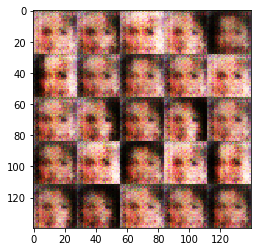

Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 3.4469
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 2.5049
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 4.4163
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 3.3769
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.7122
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 3.9469
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 2.9758
Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 2.0538
Epoch 1/1... Discriminator Loss: 2.4258... Generator Loss: 9.4200
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 2.7793


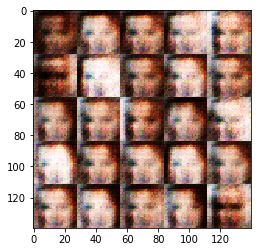

Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 2.9288
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.6895
Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 2.2987
Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 3.5140
Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 4.6069
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 3.7792
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 3.3247
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 3.0155
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 2.1913
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 2.4159


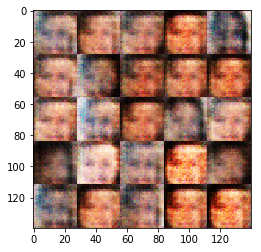

Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 3.7700
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 2.3383
Epoch 1/1... Discriminator Loss: 0.6345... Generator Loss: 1.7137
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 2.1836
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 2.2543
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.9238
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 1.8574
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.3822
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 2.9725
Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 2.1639


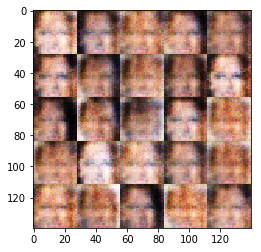

Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 2.0369
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 2.4368
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 2.7176
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 2.1249
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 2.0056
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.3760
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 2.3564
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 2.7202
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 2.0835


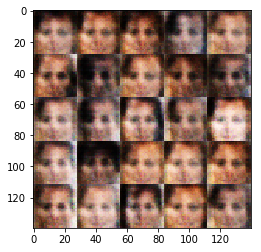

Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 2.6089
Epoch 1/1... Discriminator Loss: 0.6840... Generator Loss: 2.4432
Epoch 1/1... Discriminator Loss: 0.7253... Generator Loss: 3.5600
Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 1.8918
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 1.4659
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 1.9966
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 2.2487
Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 2.3950
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 2.4086
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 3.6578


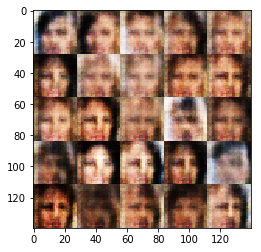

Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 3.0629
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.7918
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.6383
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 1.7683
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 1.6988
Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 2.3733
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.7748
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 2.3699
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 1.9940
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 2.5178


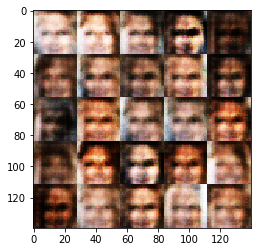

Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 2.4596
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 3.2427
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 2.8288
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.8943
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.5610
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 2.2582
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 3.1445
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 2.3842


In [24]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.